<b><h3><MSET Regression using Hatmatrix (LinearRegression)</h3></b>

In [1]:
# residual based anomaly detection
m_set_regress <- function(train, test){
  
  train_intercept = matrix(1, nrow(train), 1)
  test_intercept = matrix(1, nrow(test), 1)
  y_hat_tr = matrix(0, nrow(train), ncol(train))

  for(i in 1:ncol(train)){
    y_hat_tr[,i] = cbind(train_intercept, as.matrix(train[,-i])) %*% solve(t(cbind(train_intercept, as.matrix(train[,-i]))) %*% cbind(train_intercept, as.matrix(train[,-i]))) %*% t(cbind(train_intercept, as.matrix(train[,-i]))) %*% as.matrix(train[,i])
  }

  y_hat_ts = matrix(0, nrow(test), ncol(test))
  
  for(i in 1:ncol(test)){
    y_hat_ts[,i] = cbind(test_intercept, as.matrix(test[,-i])) %*% solve(t(cbind(train_intercept, as.matrix(train[,-i]))) %*% cbind(train_intercept, as.matrix(train[,-i])))%*% t(cbind(train_intercept, as.matrix(train[,-i]))) %*% as.matrix(train[,i])
  }
    
  # residual mat
  residual_tr_mat = train - y_hat_tr
  residual_ts_mat = test-y_hat_ts
  
  ret = list(residual_tr = residual_tr_mat, residual_ts = residual_ts_mat)

  return(ret)
}

In [2]:
# 이상/정상 판정의 기준: Bootstrap Control Limit
# 추론이 필요한 통계량, 유의확률, 붓스트랩 샘플링 횟수
bootlimit <- function(stat, alpha, m){ 
  sam_mat = matrix(0,1,m)
  ucl_mat = matrix(0,1,m)
  lcl_mat = matrix(0,1,m)
  
  for(i in 1:m){
    sample_temp = sample(stat, size=length(stat), replace=T, prob=NULL)
    ucl = quantile(sample_temp, ((1-(alpha/2))))
    lcl = quantile(sample_temp, (alpha)/2)
    ucl_mat[,i] = ucl
    lcl_mat[,i] = lcl
  }
  ucl = mean(ucl_mat)
  lcl = mean(lcl_mat)  
  
  ret = list(ucl=ucl, lcl=lcl)
  
  return(ret)
}

In [3]:
data_wd = 'C:\\Users\\User\\Desktop\\수업\\경영캡스톤\\NASA베어링데이터셋\\archive\\2nd_test\\RMS_bearing.csv'

bearing = read.table(data_wd, header=T, sep=',')

bearing_mat = as.matrix(bearing)

In [4]:
train = bearing[1:900,]
test = bearing

In [5]:
fit = m_set_regress(train, test)

In [6]:
# bootstrap based UCL, LCL
limits = matrix(0, 2, ncol(test))
for(i in 1:ncol(train)){
  cl = bootlimit(fit$residual_tr[,i], 0.05, m=100)
  limits[1,i] = cl$ucl
  limits[2,i] = cl$lcl
}

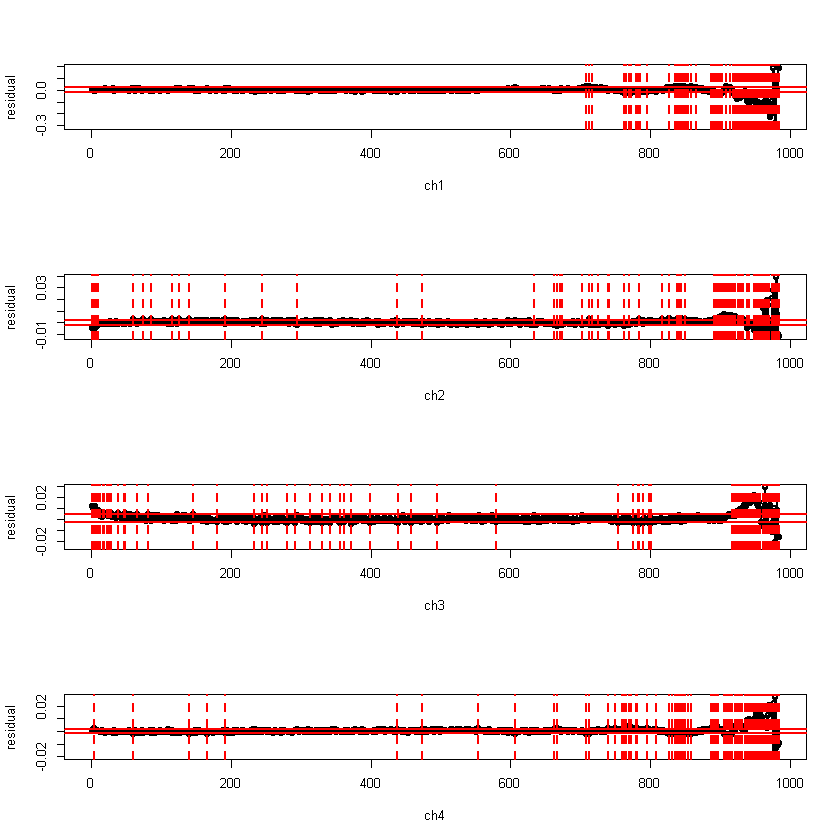

In [8]:
par(mfrow = c(4,1))
for(i in 1:ncol(test)){
  plot(fit$residual_ts[,i], col=1, lwd=2, type='o', xlab=paste('ch', i, sep=''), ylab='residual')
  abline(h=limits[1,i], col='red', lwd=2)
  abline(h=limits[2,i], col='red', lwd=2)
  abline(v = which(fit$residual_ts[,i]> limits[1,i] | fit$residual_ts[,i] < limits[2,i]), col='red', lty=2, lwd=2)
}